In [1]:
import pandas as pd
df=pd.read_csv("/content/cyberbullying_tweets (2).csv")
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [2]:

import pandas as pd
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# import optuna
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

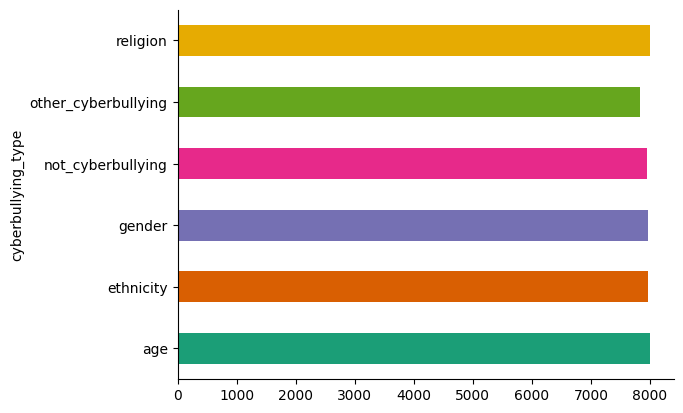

In [3]:
df.groupby('cyberbullying_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
df['cyberbullying_type'].describe()

count        47692
unique           6
top       religion
freq          7998
Name: cyberbullying_type, dtype: object

In [5]:
df.groupby('cyberbullying_type').size()

cyberbullying_type
age                    7992
ethnicity              7961
gender                 7973
not_cyberbullying      7945
other_cyberbullying    7823
religion               7998
dtype: int64

In [6]:
import re

#define a function for text cleaning
def preprocessor(text):

  #convering text to lower case
  text = text.lower()

  #remove user mentions
  text = re.sub(r'@[A-Za-z0-9]+','',text)

  #remove hashtags
  #text = re.sub(r'#[A-Za-z0-9]+','',text)

  #remove links
  text = re.sub(r'http\S+', '', text)

  #split token to remove extra spaces
  tokens = text.split()

  #join tokens by space
  return " ".join(tokens)

df['text_clean'] = df['tweet_text'].apply(preprocessor)

In [7]:
df

,tweet_text,cyberbullying_type,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"in other words #katandandre, your food was cra..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,why is #aussietv so white? #mkr #theblock #ima...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,a classy whore? or more red velvet cupcakes?
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"_gio meh. :p thanks for the heads up, but not ..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,this is an isis account pretending to be a kur...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,"black ppl aren't expected to do anything, depe..."
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner did not withhold his disappointment. tu...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,i swear to god. this dumb nigger bitch. i have...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck you rt : if youre a nigger fucking un...


In [8]:
df.drop_duplicates(subset = ['tweet_text'], inplace = True)
df.dropna(inplace = True)

In [9]:
df['cyberbullying_type'].nunique()

6

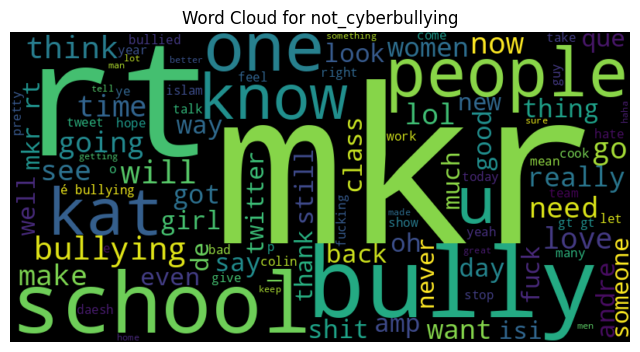

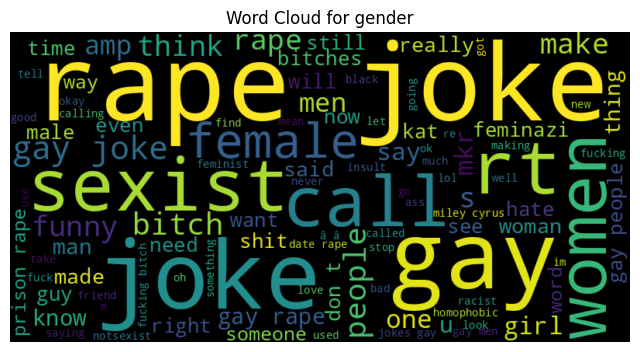

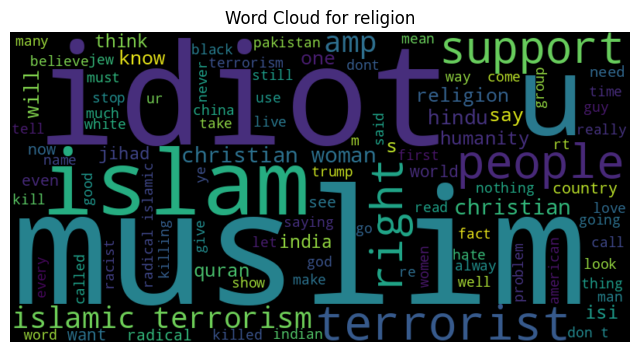

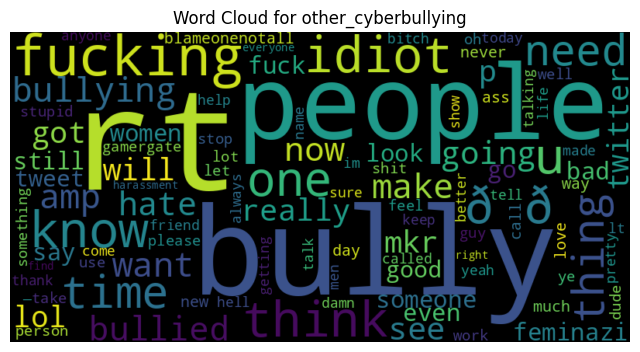

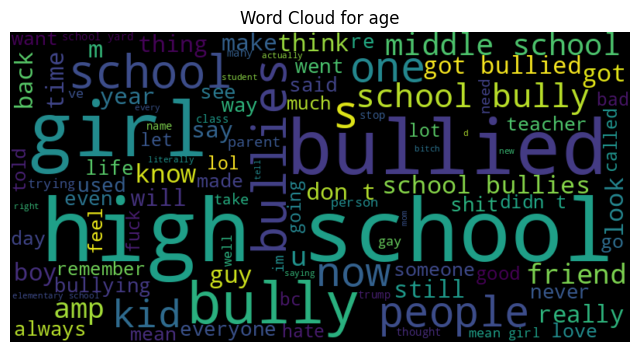

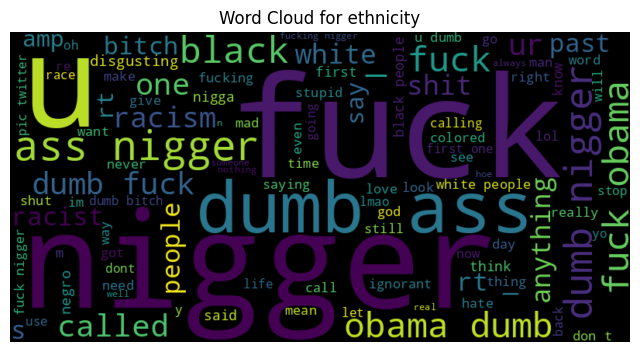

In [10]:
for label in df['cyberbullying_type'].unique():
    plt.figure(figsize=(8,6))
    wc = WordCloud(width=800, height=400, max_words=100).generate(' '.join(df[df['cyberbullying_type'] == label]['text_clean']))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {label}')
    plt.axis('off')
    plt.show()

In [11]:
!pip install --upgrade pyarrow
!pip install --upgrade datasets


  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)


In [15]:
# df = df.apply(lambda x: x.sample(frac=1).reset_index(drop=True)).iloc[:5000, :]


In [17]:
from transformers import AutoTokenizer
from datasets import Dataset
import torch
import pandas as pd

# Assuming df is already loaded
df = df[['text_clean', 'cyberbullying_type']]

# Step 2: Tokenization
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples['text_clean'], truncation=True, padding=True)

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Apply the preprocessing (tokenization)
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Encode labels
labels = list(set(df['cyberbullying_type']))
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Add label encoding to the dataset
tokenized_dataset = tokenized_dataset.map(lambda x: {'labels': label2id[x['cyberbullying_type']]})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [19]:
df.nunique()

text_clean            4974
cyberbullying_type       6
dtype: int64

In [26]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Step 1: Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))
model.to(device)


# Step 3: Define a compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Step 2: Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Step 3: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,  # Assumes dataset split into train/test earlier
    eval_dataset=tokenized_dataset,   # Use the same for simplicity; ideally, split dataset into train/test
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
import numpy as np

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.782659,0.171400,0.054256,0.207482,0.171400
2,1.793600,1.717789,0.314600,0.273982,0.387868,0.314600
3,1.793600,1.630312,0.406400,0.384834,0.414071,0.406400


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=939, training_loss=1.762814652805511, metrics={'train_runtime': 680.7703, 'train_samples_per_second': 22.034, 'train_steps_per_second': 1.379, 'total_flos': 1770476208146208.0, 'train_loss': 1.762814652805511, 'epoch': 3.0})

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.451006,0.514200,0.486930,0.569876,0.514200
2,1.596500,1.079770,0.700000,0.684965,0.709262,0.700000
3,1.596500,0.932019,0.766400,0.756829,0.773602,0.766400


TrainOutput(global_step=939, training_loss=1.4327400378144968, metrics={'train_runtime': 688.0346, 'train_samples_per_second': 21.801, 'train_steps_per_second': 1.365, 'total_flos': 1770476208146208.0, 'train_loss': 1.4327400378144968, 'epoch': 3.0})

In [31]:
trainer.evaluate()

{'eval_loss': 0.932019054889679,
 'eval_accuracy': 0.7664,
 'eval_f1': 0.7568291876603228,
 'eval_precision': 0.7736024897161373,
 'eval_recall': 0.7664,
 'eval_runtime': 34.6124,
 'eval_samples_per_second': 144.457,
 'eval_steps_per_second': 9.043,
 'epoch': 3.0}

In [35]:
from transformers import AutoTokenizer
from datasets import Dataset
import torch
import pandas as pd

# Assuming df is already loaded
df = df[['text_clean', 'cyberbullying_type']]

# Step 2: Tokenization
model_name1 = 'distilbert-base-uncased'
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)

def preprocess_function(examples):
    return tokenizer1(examples['text_clean'], truncation=True, padding=True)

# Convert to Hugging Face Dataset
dataset1 = Dataset.from_pandas(df)

# Apply the preprocessing (tokenization)
tokenized_dataset1 = dataset.map(preprocess_function, batched=True)

# Encode labels
labels1 = list(set(df['cyberbullying_type']))
label2id1 = {label: i for i, label in enumerate(labels1)}
id2label1 = {i: label for i, label in enumerate(labels1)}

# Add label encoding to the dataset
tokenized_dataset1 = tokenized_dataset1.map(lambda x: {'labels': label2id1[x['cyberbullying_type']]})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [36]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Step 1: Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))
model1.to(device)


# Step 3: Define a compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Step 2: Define training arguments
training_args1 = TrainingArguments(
    output_dir='./results1',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs1',
)

# Step 3: Initialize the Trainer
trainer1= Trainer(
    model=model1,
    args=training_args1,
    train_dataset=tokenized_dataset1,  # Assumes dataset split into train/test earlier
    eval_dataset=tokenized_dataset1,   # Use the same for simplicity; ideally, split dataset into train/test
    tokenizer=tokenizer1,
    compute_metrics=compute_metrics
)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
trainer1.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.783539,0.184400,0.090523,0.066799,0.184400
2,1.797300,1.769421,0.219000,0.135737,0.360868,0.219000
3,1.797300,1.727309,0.287000,0.238006,0.297078,0.287000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=939, training_loss=1.7838173115723177, metrics={'train_runtime': 680.3135, 'train_samples_per_second': 22.049, 'train_steps_per_second': 1.38, 'total_flos': 1770476208146208.0, 'train_loss': 1.7838173115723177, 'epoch': 3.0})